In [408]:
using Pkg
if !haskey(Pkg.installed(), "Images") || !haskey(Pkg.installed(), "ImageMagick") || !haskey(Pkg.installed(), "FileIO") || !haskey(Pkg.installed(), "Glob")
    println("Installing required packages...")
    Pkg.add.(["Images", "ImageMagick", "FileIO", "Glob"])
end



using LinearAlgebra
using GenericLinearAlgebra
using Images
using FileIO
using Glob
using ImageMagick  # pode ser necessário para JPEG


┌ Warning: Pkg.installed() is deprecated
└ @ Pkg C:\Users\mathe\.julia\juliaup\julia-1.10.2+0.x64.w64.mingw32\share\julia\stdlib\v1.10\Pkg\src\Pkg.jl:744
┌ Warning: Pkg.installed() is deprecated
└ @ Pkg C:\Users\mathe\.julia\juliaup\julia-1.10.2+0.x64.w64.mingw32\share\julia\stdlib\v1.10\Pkg\src\Pkg.jl:744
┌ Warning: Pkg.installed() is deprecated
└ @ Pkg C:\Users\mathe\.julia\juliaup\julia-1.10.2+0.x64.w64.mingw32\share\julia\stdlib\v1.10\Pkg\src\Pkg.jl:744
┌ Warning: Pkg.installed() is deprecated
└ @ Pkg C:\Users\mathe\.julia\juliaup\julia-1.10.2+0.x64.w64.mingw32\share\julia\stdlib\v1.10\Pkg\src\Pkg.jl:744


##  Objetivo

Dado uma **matriz unitária ou ortogonal** $A \in \mathbb{R}^{(m+n) \times (p+q)}$, queremos fazer a **CS decomposition**:

$$
A = 
\begin{bmatrix}
U_1 & 0 \\
0 & U_2
\end{bmatrix}
\begin{bmatrix}
C & -S & 0 \\
S & C & 0 \\
0 & 0 & I
\end{bmatrix}
\begin{bmatrix}
V_1^\top & 0 \\
0 & V_2^\top
\end{bmatrix}
$$

Esse é o caso mais geral (com bloco identidade no final se sobrarem dimensões), mas vamos focar no **caso simples** para clareza:

### Suponha:

$$
A \in \mathbb{R}^{(m + n) \times r},\quad \text{com } m = n = r
\Rightarrow A \in \mathbb{R}^{2r \times r}
$$

E seja:

$$
A = \begin{bmatrix}
A_1 \\
A_2
\end{bmatrix},\quad A_1, A_2 \in \mathbb{R}^{r \times r}
$$




## Passo a passo da CSD via SVD


### - **Passo 1: Obter os subespaços**

Seja:

* $A_1 \in \mathbb{R}^{r \times r}$
* $A_2 \in \mathbb{R}^{r \times r}$

Você quer decompor $A$ entendendo a **relação geométrica entre os subespaços linha** de $A_1$ e $A_2$.



### - **Passo 2: Aplicar SVD em $A_1$**

Faça:

$$
A_1 = U_1 \Sigma_1 V^\top
$$

* $U_1 \in \mathbb{R}^{r \times r}$ (ortogonal)
* $\Sigma_1 = \text{diag}(\sigma_1^{(1)}, \dots, \sigma_r^{(1)})$
* $V \in \mathbb{R}^{r \times r}$ (ortogonal)


### - **Passo 3: Aplicar SVD em $A_2$** usando **mesmo $V$**

Agora, defina:

$$
\tilde{A}_2 = A_2 V
$$

E aplique SVD em $\tilde{A}_2$:

$$
\tilde{A}_2 = U_2 \Sigma_2
$$

Você agora tem:

* $A_1 = U_1 \Sigma_1 V^\top$
* $A_2 = U_2 \Sigma_2 V^\top$

Essas decomposições **compartilham a mesma base $V$** (isso é importante e possível porque $A$ é unitária).



### - **Passo 4: Obter os ângulos principais**

Agora, queremos achar os ângulos $\theta_i$ tais que:

$$
\cos(\theta_i) = \sigma_i^{(1)}, \quad \sin(\theta_i) = \sigma_i^{(2)}
$$

Como $A$ é unitária:

$$
A_1^\top A_1 + A_2^\top A_2 = I
\Rightarrow \Sigma_1^2 + \Sigma_2^2 = I
$$

Portanto, podemos definir:

$$
\theta_i = \arccos(\sigma_i^{(1)}) = \arcsin(\sigma_i^{(2)})
$$





### - **Passo 5: Construir os blocos da CSD**

* $C = \mathrm{diag}(\cos(\theta_1), \dots, \cos(\theta_r))$
* $S = \mathrm{diag}(\sin(\theta_1), \dots, \sin(\theta_r))$

A matriz do meio da CSD será:

$$
\begin{bmatrix}
C & -S \\
S & C
\end{bmatrix}
$$

E a CSD completa é:

$$
A = 
\begin{bmatrix}
U_1 & 0 \\
0 & U_2
\end{bmatrix}
\begin{bmatrix}
C & -S \\
S & C
\end{bmatrix}
V^\top
$$



##  Recapitulando (Fluxo)

1. **Particione** $A$ em $A_1$ e $A_2$
2. **SVD** de $A_1 = U_1 \Sigma_1 V^\top$
3. Defina $\tilde{A}_2 = A_2 V$, depois faça $\tilde{A}_2 = U_2 \Sigma_2$
4. Calcule $\theta_i = \arccos(\sigma_i^{(1)})$
5. Monte $C, S$, e a decomposição completa



###  Observação importante

Esse processo depende de $A$ ser **unitária/ortogonal** — ou seja, $A^\top A = I$. Caso contrário, essa relação $\Sigma_1^2 + \Sigma_2^2 = I$ **não se sustentaria**, e os cossenos e senos não formariam uma matriz de rotação.



In [409]:
function build_csd_input_matrix(D1::Matrix{Float64}, D2::Matrix{Float64})
    # D1: m × d (m amostras, d features) - dataset 1
    # D2: n × d (n amostras, d features) - dataset 2

    # Passo 1: QR dos transpostos (colunas de D1 e D2 como vetores base)
    Q1, R1 = qr(D1')  
    Q2, R2 = qr(D2') 
    
    
    if size(R1, 1) == size(R1, 2)
        m= size(Q1, 1)
        n = size(R1, 2)
        R1_full = zeros(m, n)
        R1_full[1:n, :] = R1
    else
        R1_full = R1
    end
    if size(R2, 1) == size(R2, 2)
        m= size(Q2, 1)
        n = size(R2, 2)
        R2_full = zeros(m, n)
        R2_full[1:n, :] = R2      
    else
        R2_full = R2  
    end
    

    # Passo 2: Ortonormaliza a união dos subespaços de Q1 e Q2
    Q_all, _ = qr([Q1 Q2])  # Q_all ∈ ℝ^{d × r}, com r ≤ m + n

    # Passo 3: Projeta Q1 e Q2 no subespaço comum Q_all
    A1 = Q_all' * Q1  # ∈ ℝ^{r × m}
    A2 = Q_all' * Q2  # ∈ ℝ^{r × n}
    
    # Passo 4: Constrói a matriz A com blocos
    top = hcat(A1, zeros(size(A1, 1), size(A2, 2)))    # [A1  0]
    bottom = hcat(zeros(size(A2, 1), size(A1, 2)), A2)  # [0   A2]
    A = vcat(top, bottom)  # ∈ ℝ^{2r × (m + n)}

    return A, Q_all, R1_full, R2_full
end

build_csd_input_matrix (generic function with 1 method)

In [410]:
function rebuild_datasets_matrices(A, Q_all, R1, R2)
    # A: matriz de entrada
    # Q_all: base ortonormal comum
    # R1: matriz triangular superior de D1
    # R2: matriz triangular superior de D2

    r = size(Q_all, 2)  # dimensão do subespaço comum

    A1 = A[1:r, 1:size(R1, 1)] 
    D1_reconstructed = (Q_all * (A1' \ R1))'
   
    A2 = A[r+1:end, end-size(R2,1)+1:end] 
    D2_reconstructed = (Q_all * (A2' \ R2))'
    
    # D1_reconstructed: matriz reconstruída de D1
    # D2_reconstructed: matriz reconstruída de D2

    # Retorna as matrizes reconstruídas
    return D1_reconstructed, D2_reconstructed
    
end

rebuild_datasets_matrices (generic function with 1 method)

In [411]:
# Exemplo com dados aleatórios
m = 5  # amostras de D1
n = 7  # amostras de D2
d = 6  # número de features

D1 = randn(m, d)  # dataset 1
D2 = randn(n, d)  # dataset 2

A, Q_all, R1, R2 = build_csd_input_matrix(D1, D2)

([1.0000000000000002 5.551115123125783e-17 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … -0.5615487960487998 0.3408828549059809; 0.0 0.0 … -0.09825916570592808 -0.535508356320856], LinearAlgebra.QRCompactWYQ{Float64, Matrix{Float64}, Matrix{Float64}}([1.0000000000000002 5.551115123125783e-17 … 0.012487221276702098 0.1474798977288459; 0.123254823571734 1.0 … 0.31367528967076713 0.6171351366058478; … ; -0.23554126474087458 0.5933565002387512 … -0.5615487960487998 0.3408828549059809; -0.25913642912249857 -0.14558643193498913 … -0.09825916570592808 -0.535508356320856], [1.5594248442691017 0.2807881155136981 … -0.5409875080198984 0.0; 0.0 1.0378943959172144 … 0.044244984683311 0.0; … ; 7.263839958816e-312 6.952398619534e-310 … 1.0383176570427006 0.0; 0.0 0.0 … 5.0e-324 0.0]), [-1.8502140508126723 0.2505949390285238 … 1.5544527467132416 -0.5586262465149332; 0.0 -1.2420265383366882 … 0.4686297405402939 -0.061189121576904704; … ; 0.0 0.0 … 0.0 -1.0559972326716176; 0.0 0.0 … 0.0 0.0], [2.24158936

In [412]:
# Exibir a matriz A
display(A)

12×12 Matrix{Float64}:
  1.0           5.55112e-17  …   0.0         0.0         0.0
  0.0           1.0              0.0         0.0         0.0
  1.11022e-16   0.0              0.0         0.0         0.0
  2.01228e-16  -3.33067e-16      0.0         0.0         0.0
  0.0           2.22045e-16      0.0         0.0         0.0
 -5.55112e-17   5.55112e-17  …   0.0         0.0         0.0
  0.0           0.0             -0.0424137   0.0124872   0.14748
  0.0           0.0              0.513908    0.313675    0.617135
  0.0           0.0             -0.292254    0.572645    0.229111
  0.0           0.0             -0.446647    0.498535   -0.376738
  0.0           0.0          …  -0.488692   -0.561549    0.340883
  0.0           0.0              0.458665   -0.0982592  -0.535508

In [413]:
if A'*A ≈ I
    println("A matriz A é ortonormal")
else
    println("A matriz A não é ortonormal")
    
end

A matriz A é ortonormal


In [414]:
D1_reconstructed, D2_reconstructed = rebuild_datasets_matrices(A, Q_all, R1, R2)

if D1_reconstructed ≈ D1 && D2_reconstructed ≈ D2
    println("As matrizes reconstruídas são equivalentes às originais!")
else
    println("As matrizes reconstruídas NÃO são equivalentes às originais.")
    
end

As matrizes reconstruídas são equivalentes às originais!


In [415]:
function load_images_as_dataset(folder_path::String)
    # Lista todos os arquivos JPEG na pasta
    image_paths = Glob.glob("*.jpg", folder_path)
    num_images = length(image_paths)

    if num_images == 0
        error("Nenhuma imagem encontrada na pasta.")
    end

    # Carrega uma imagem para obter dimensões
    img_sample = load(image_paths[1])
    img_rgb = convert(Array{RGB{N0f8}}, img_sample)
    h, w = size(img_rgb)[1:2]

    println("Dimensões da imagem: $h x $w")

    # Inicializa matriz dataset
    dataset = zeros(Float64, num_images, h * w * 3)

    for (i, path) in enumerate(image_paths)
        img = load(path)
        img_rgb = convert(Array{RGB{N0f8}}, img)
        r = Float64.(channelview(img_rgb)[1, :, :])
        g = Float64.(channelview(img_rgb)[2, :, :])
        b = Float64.(channelview(img_rgb)[3, :, :])
        dataset[i, :] = vcat(vec(r), vec(g), vec(b))
    end

    return dataset, h, w
end


load_images_as_dataset (generic function with 1 method)

In [416]:
function reconstruct_image_from_vector(X::Matrix{Float64}, h::Int, w::Int, img_num::Int)
    vec_img = X[img_num, :]
    n_pixels = h * w

    r = reshape(vec_img[1:n_pixels], h, w)
    g = reshape(vec_img[n_pixels+1:2*n_pixels], h, w)
    b = reshape(vec_img[2*n_pixels+1:3*n_pixels], h, w)

    img_rgb = colorview(RGB, r, g, b)
    return img_rgb
end

reconstruct_image_from_vector (generic function with 2 methods)

In [417]:
#"D:\Docs matheus\UFRJ\7-Setimo Periodo\Alg. Lininear Aplicada\Trabalho final\CSD of subspaces\ace of spades"

folder = raw"D:\Docs matheus\UFRJ\7-Setimo Periodo\Alg. Lininear Aplicada\Trabalho final\Dataset PlayingCards\train\jack of hearts"
X, h, w = load_images_as_dataset(folder)
size(X) 

Dimensões da imagem: 224 x 224


(168, 150528)

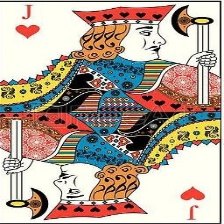

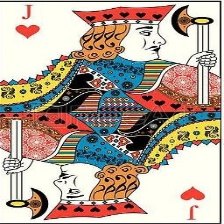

In [418]:
num = 42  # Número da imagem que você quer reconstruir
img9 = load(folder * "\\" * lpad(string(num), 3, "0") * ".jpg")
display(img9)

img9_reconstruct= reconstruct_image_from_vector(X, h, w, num)
display(img9_reconstruct)

In [419]:
function display_image_grid(X::Matrix{Float64}, img_size::Tuple{Int,Int}, indices::Vector{Int}; grid_shape::Tuple{Int,Int}=nothing)
    n_imgs = length(indices)
    h, w = img_size

    # Define grid shape if not provided
    if grid_shape === nothing
        ncols = ceil(Int, sqrt(n_imgs))
        nrows = ceil(Int, n_imgs / ncols)
    else
        nrows, ncols = grid_shape
    end

    # Create empty canvas for each channel
    grid_r = zeros(Float64, nrows*h, ncols*w)
    grid_g = zeros(Float64, nrows*h, ncols*w)
    grid_b = zeros(Float64, nrows*h, ncols*w)

    n_pixels = h * w

    for (k, idx) in enumerate(indices)
        row = div(k-1, ncols)
        col = mod(k-1, ncols)
        img_vec = X[idx, :]
        r = reshape(img_vec[1:n_pixels], h, w)
        g = reshape(img_vec[n_pixels+1:2*n_pixels], h, w)
        b = reshape(img_vec[2*n_pixels+1:3*n_pixels], h, w)
        grid_r[(row*h+1):(row+1)*h, (col*w+1):(col+1)*w] .= r
        grid_g[(row*h+1):(row+1)*h, (col*w+1):(col+1)*w] .= g
        grid_b[(row*h+1):(row+1)*h, (col*w+1):(col+1)*w] .= b
    end

    display(colorview(RGB, grid_r, grid_g, grid_b))
end


display_image_grid (generic function with 1 method)

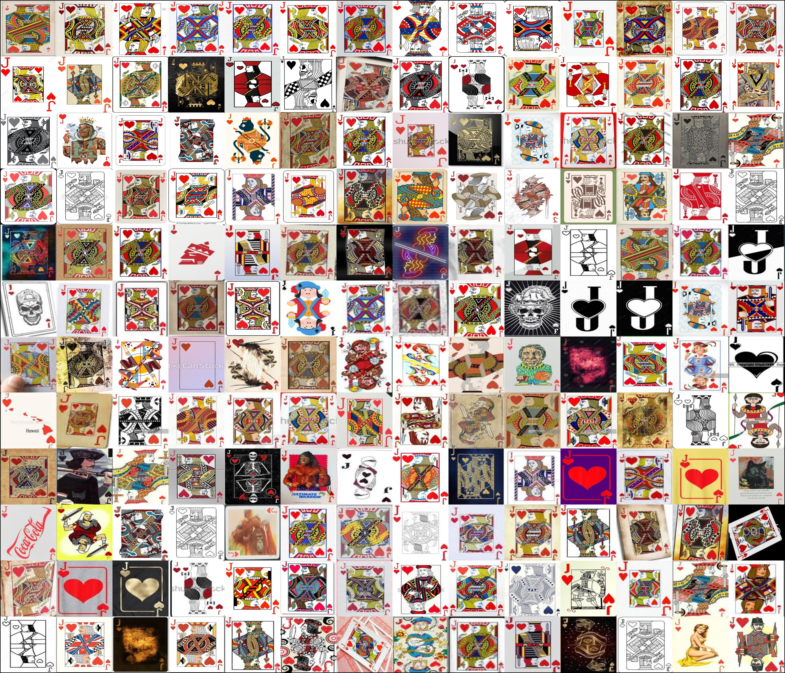

Número de imagens no dataset: 168
Número de linhas do grid: 12
Número de colunas do grid: 14


In [420]:
function best_grid_shape(n_imgs::Int)
    # Procura divisores de n_imgs para formar um grid mais "quadrado" possível
    best_rows, best_cols = 1, n_imgs
    min_diff = n_imgs
    for rows in 1:floor(Int, sqrt(n_imgs))
        if n_imgs % rows == 0
            cols = div(n_imgs, rows)
            if abs(rows - cols) < min_diff
                best_rows, best_cols = rows, cols
                min_diff = abs(rows - cols)
            end
        end
    end
    # Se n_imgs é primo, usa aproximação quadrada
    if best_rows == 1
        best_rows = floor(Int, sqrt(n_imgs))
        best_cols = ceil(Int, n_imgs / best_rows)
    end
    return best_rows, best_cols
end

# Exemplo de uso:
size_dataset = size(X, 1)
grid_rows, grid_cols = best_grid_shape(size_dataset)
println("Número de imagens no dataset: ", size_dataset)
println("Número de linhas do grid: ", grid_rows)
println("Número de colunas do grid: ", grid_cols)
display_image_grid(X, (h, w), collect(1:size_dataset); grid_shape=(grid_rows, grid_cols))